In [202]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [213]:
house_price = 900000
down_payment = 0.2
federal_tax = 0.32
inflation = (1+0.02)**(1/12.0)-1
years = 30
months = 12*years
loan_amount = house_price*(1-down_payment)
    
apr = np.linspace(start=0.025,stop=0.039)
apr = apr/12

def loans_cal(apr,x):
    interest_array = np.zeros(months+1)
    principal_array = np.zeros(months+1)
    principal_array[0] = loan_amount
    for m in range(1,months+1):
        interest_array[m] = principal_array[m-1]*apr
        principal_array[m] = principal_array[m-1] - (x - interest_array[m])
    return interest_array,principal_array

def objective_func(apr,x):
    total_loan = 0
    interest,_=loans_cal(apr,x)
    total_loan =loan_amount+sum(interest)
    return abs(x*months-total_loan)

In [214]:

loan_mv_all = np.zeros(len(apr))
int_mv_all = np.zeros(len(apr))

for i in range(len(apr)):
    res = minimize(partial(objective_func,apr[i]), 1600,method = 'Nelder-Mead')
    loan_mv = 0
    int_mv = 0
    interest_array,_ = loans_cal(apr[i],res.x[0])
    for m in range(1,months+1):
        loan_mv += (res.x[0]-interest_array[m]*federal_tax)/(1+inflation)**m
        int_mv += interest_array[m]*(1-federal_tax)/(1+inflation)**m
    loan_mv_all[i] = loan_mv
    int_mv_all[i] = int_mv

In [215]:
loan_df = pd.DataFrame(index=list(range(months)),columns=['interest','principal','monthly_payment'])
res = minimize(partial(objective_func,0.029/12), 1600,method = 'Nelder-Mead')
interest_array,_ = loans_cal(0.029/12,res.x[0])
loan_df.interest = interest_array[1:]
loan_df.monthly_payment=res.x[0]
loan_df.principal = loan_df.monthly_payment-loan_df.interest

Text(0.5, 1.0, 'sensitivity - discounted interest payment to principal')

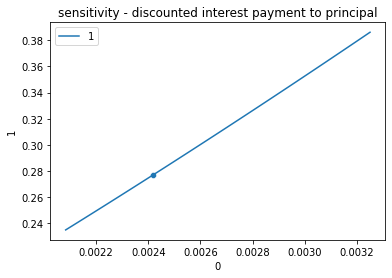

In [216]:
rate_price = pd.concat([pd.Series(apr),pd.Series(int_mv_all)],axis=1).set_index(0)/loan_amount
current = np.where((0.029/12<=rate_price.index)&(0.0293/12>=rate_price.index))[0][0]
rate_price.plot()
sns.scatterplot(x=0,y=1,data=rate_price.reset_index().iloc[[current],:])
plt.title('sensitivity - discounted interest payment to principal')

In [217]:
loan_df

,interest,principal,monthly_payment
0,1740.000000,1256.855857,2996.855857
1,1736.962598,1259.893258,2996.855857
2,1733.917856,1262.938000,2996.855857
3,1730.865756,1265.990101,2996.855857
4,1727.806280,1269.049577,2996.855857
...,...,...,...
355,35.950945,2960.904912,2996.855857
356,28.795425,2968.060432,2996.855857
357,21.622612,2975.233245,2996.855857
358,14.432465,2982.423392,2996.855857
